# Задача
В этой работе вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

В этой задаче для обучения будут использовать 2 алгоритма:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

# Решение

Загрузите набор данных *data.adult.csv* с помощью `pandas` (скачать можно [здесь](https://drive.google.com/file/d/1Lo47fXx1RrJG3v9E-Gck1T45n5bJ_SJf/view?usp=sharing), или с помощью скрипта ниже). Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [14]:
# !gdown 1Lo47fXx1RrJG3v9E-Gck1T45n5bJ_SJf

In [15]:
import pandas as pd

csv = 'data.adult.csv'
data = pd.read_csv(csv)

print(data.head())


   age  workclass  fnlwgt     education  education-num      marital-status  \
0   34  Local-gov  284843       HS-grad              9       Never-married   
1   40    Private  190290  Some-college             10            Divorced   
2   36  Local-gov  177858     Bachelors             13  Married-civ-spouse   
3   22    Private  184756  Some-college             10       Never-married   
4   47    Private  149700     Bachelors             13  Married-civ-spouse   

        occupation   relationship   race     sex  capital-gain  capital-loss  \
0  Farming-fishing  Not-in-family  Black    Male           594             0   
1            Sales  Not-in-family  White    Male             0             0   
2   Prof-specialty      Own-child  White    Male             0             0   
3            Sales      Own-child  White  Female             0             0   
4     Tech-support        Husband  White    Male         15024             0   

   hours-per-week >50K,<=50K  
0              60  

## Анализ и предобработка данных

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 
1. Проверьте есть ли в данных пропущенные значения (здесь они обозначены как "?"). Удалите из выборки все объекты с пропусками.
2. Выделите 60% выборки для обучения и дальнейшего анализа.
3. Обратите внимание, что не все признаки являются вещественными (числовыми). Сначала их необходимо проанализировать и по необходимости предобработать. Все шаги предобработки поясните текстом.
4. Целевую переменную (ту, которую мы хотим предсказывать) можно выделить в отдельную переменную и преобразуйте к бинарному формату (НЕ забудьте удалить ее из датасета, когда будете обучать модель).



### 1. Проверка и удаление пропущенных значений

In [16]:
data = data.replace('?', pd.NA).dropna()


### 2. Разделение выборки на обучающую и тестовую

In [17]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.4, random_state=42)


### 3. Анализ и предобработка признаков

In [18]:
from sklearn.preprocessing import StandardScaler

# Анализ типов данных
print(train_data.dtypes)

# Преобразование категориальных признаков в числовые
numerical_columns = train_data.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = train_data.select_dtypes(include=['object']).columns

# Проверка, что в обучающей и тестовой выборках одинаковые столбцы
train_data, test_data = train_data.align(test_data, join='inner', axis=1)


age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
>50K,<=50K        object
dtype: object


1) Проверяем типы данных в датасете.
2) Преобразуем категориальные признаки в числовые
3) Убедились, что в обучающей и тестовой выборках одинаковые столбцы после преобразования.

### 4. Преобразование целевой переменной и удаление ее из датасета

In [19]:
# Преобразование целевой переменной к бинарному формату
train_data['>50K,<=50K'] = train_data['>50K,<=50K'].apply(lambda x: 1 if x == '>50K' else 0)
test_data['>50K,<=50K'] = test_data['>50K,<=50K'].apply(lambda x: 1 if x == '>50K' else 0)

# Выделение целевой переменной
goal_var_train = train_data['>50K,<=50K']
goal_var_test = test_data['>50K,<=50K']

# Удаление целевой переменной из датасета
train_data = train_data.drop(columns=['>50K,<=50K'])
test_data = test_data.drop(columns=['>50K,<=50K'])
categorical_columns = categorical_columns.drop('>50K,<=50K')

scaler = StandardScaler()
train_data_fit = scaler.fit_transform(train_data[numerical_columns])
test_data_fit = scaler.fit_transform(test_data[numerical_columns])


При обучении алгоритмов стоит обращать внимание не только на их качество, но и каким образом они работают с данными. Давайте посмотрим на значения самих признаков.

Что можете сказать о разбросе данных и сбалансированности выборки? Какой из алгоритмов, на ваш взгляд окажется более качественным: логический или метрический? Почему?

In [20]:
import numpy as np

# Проверка разброса данных
def check_data_spread(db):
    spread_info = {}
    for column in db.columns:
        if db[column].dtype in [np.float64, np.int64]:
            spread_info[column] = {
                'std': db[column].std(),
            }
    return spread_info


spread_info_train = check_data_spread(train_data)
spread_info_test = check_data_spread(test_data)

print("Разброс данных в обучающей выборке:")
for col, info in spread_info_train.items():
    print(f"{col}: {info}")

print("\nРазброс данных в тестовой выборке:")
for col, info in spread_info_test.items():
    print(f"{col}: {info}")

# Проверка сбалансированности выборки
def check_balance(y):
    balance_info = y.value_counts(normalize=True)
    return balance_info

balance_info_train = check_balance(goal_var_train)
balance_info_test = check_balance(goal_var_test)

print("\nСбалансированность обучающей выборки:")
print(balance_info_train)

print("\nСбалансированность тестовой выборки:")
print(balance_info_test)


Разброс данных в обучающей выборке:
age: {'std': np.float64(13.107200803391363)}
fnlwgt: {'std': np.float64(104933.12718940542)}
education-num: {'std': np.float64(2.548620910288564)}
capital-gain: {'std': np.float64(7288.006849149569)}
capital-loss: {'std': np.float64(405.4489163900252)}
hours-per-week: {'std': np.float64(11.954703525065524)}

Разброс данных в тестовой выборке:
age: {'std': np.float64(13.115392393011696)}
fnlwgt: {'std': np.float64(108286.68113171161)}
education-num: {'std': np.float64(2.5598723409057778)}
capital-gain: {'std': np.float64(6549.265495458534)}
capital-loss: {'std': np.float64(405.27958647483655)}
hours-per-week: {'std': np.float64(12.145750218128072)}

Сбалансированность обучающей выборки:
>50K,<=50K
0    0.741746
1    0.258254
Name: proportion, dtype: float64

Сбалансированность тестовой выборки:
>50K,<=50K
0    0.745561
1    0.254439
Name: proportion, dtype: float64


Разброс данных для различных параметров сильно отличается, где-то он большой, где-то не оченю. Сбалансированность не очень хорошая: 75/25. Метрические алгоритмы, например k-средних, хорошо масштабируются и могут эффективно работать с большими наборами данных. Так как данные несбалансированы и имеют высокий разброс, метрические модели могут быть более гибкими и способны лучше справляться с этими особенностями данных.

## Добавление категориальных признаков

Добавим к предобработанным вещественным признакам категориальные. Но для начала их тоже необходимо предобработать.

Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) / [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) из sklearn).

После преобразования категориальных признаков, добавьте их к вещественным предобработанным данным для обучения.

>PS Напоминаю, что важно удалить колонку с целевым значением

In [21]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first')
categorical_train_encoded = encoder.fit_transform(train_data[categorical_columns])
categorical_test_encoded = encoder.fit_transform(test_data[categorical_columns])

# Объединение вещественных и категориальных признаков
train_data_processed = np.hstack([train_data_fit, categorical_train_encoded.toarray()])


## Обучение классификаторов

В начале посмотрим, как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 2 алгоритма:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

Для начала выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 
Остальные параметры оставляйте в значениях по умолчанию.

Для каждого алгоритма подберите оптимальные значения указанных гиперпараметров. Постройте график среднего значения качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал.

Что вы можете сказать о получившихся графиках? Какой алгоритм справился лучше? Какой быстрее? Почему?

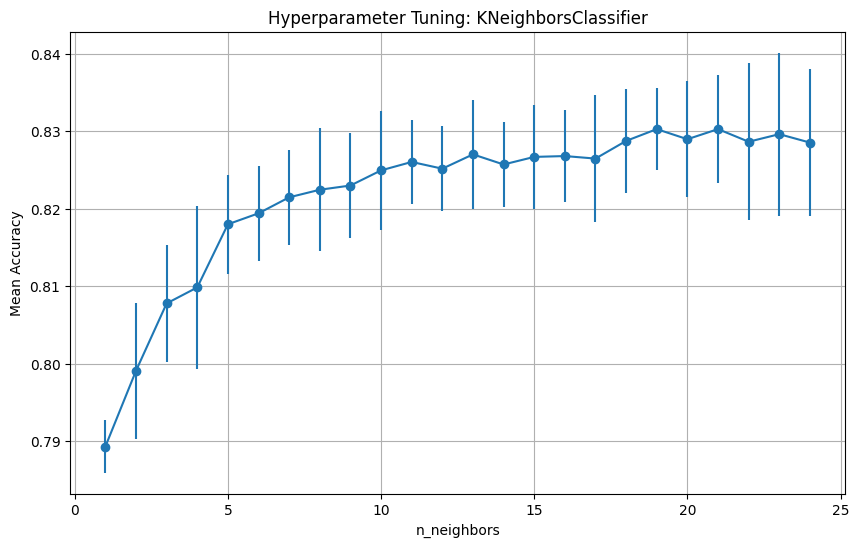

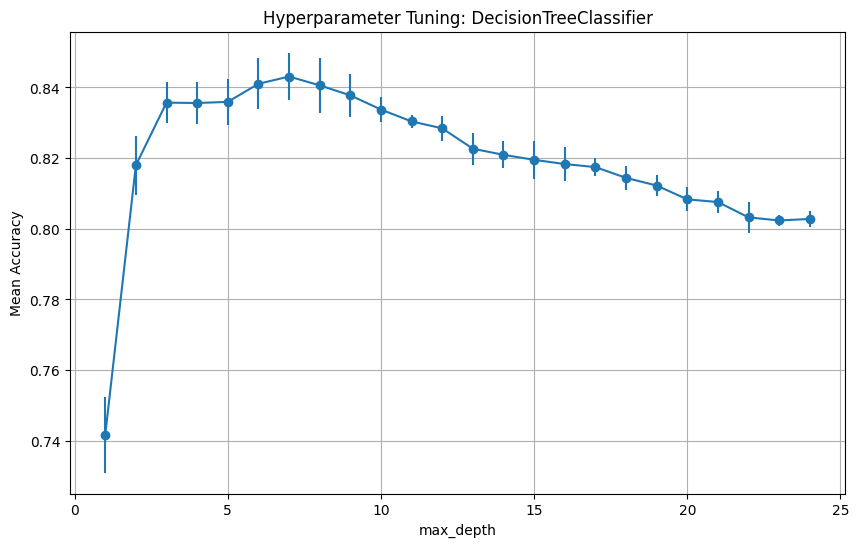

In [22]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier

# Функция для подбора гиперпараметров и построения графиков
def plot_hyperparameter_tuning(model, param_name, param_range, xx, yy):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mean_scores = []
    std_scores = []

    for param_value in param_range:
        model.set_params(**{param_name: param_value})
        scores = cross_val_score(model, xx, yy, cv=kf, scoring='accuracy')
        mean_scores.append(np.mean(scores))
        std_scores.append(np.std(scores))

    plt.figure(figsize=(10, 6))
    plt.errorbar(param_range, mean_scores, yerr=std_scores, fmt='-o')
    plt.xlabel(param_name)
    plt.ylabel('Mean Accuracy')
    plt.title(f'Hyperparameter Tuning: {model.__class__.__name__}')
    plt.grid(True)
    plt.show()


# Подбор гиперпараметров для kNN
knn = KNeighborsClassifier()
# Выбор диапазона для параметра
param_range_knn = range(1, 25) 
plot_hyperparameter_tuning(knn, 'n_neighbors', param_range_knn, train_data_processed, goal_var_train)

# Подбор гиперпараметров для DecisionTree
dt = DecisionTreeClassifier()
# Выбор диапазона для параметра
param_range_dt = range(1, 25)
plot_hyperparameter_tuning(dt, 'max_depth', param_range_dt, train_data_processed, goal_var_train)


Дерево решений быстро на этапе предсказания, так как требует только прохождения по дереву. k-NN медленный на этапе предсказания, так как требует вычисления расстояний до всех объектов в обучающем наборе.

## PCA преобразование

Теперь попробуем сделать преобразрование данных с помощью PCA. Выберите оптимальное количество компонент и преобразуйте данные. Объясните свой выбор.

Optimal number of components: 26


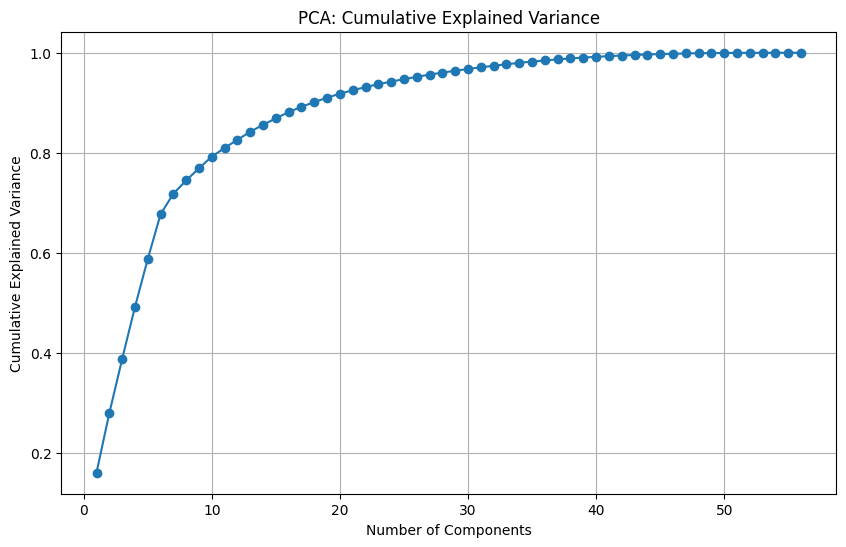

In [23]:
from sklearn.decomposition import PCA

data_train, data_test, labels_train, labels_test = train_test_split(train_data_processed, goal_var_train, test_size=0.4, random_state=42)

# Применение PCA
pca = PCA()
train_data_pca = pca.fit_transform(data_train)
test_data_pca = pca.transform(data_test)

# Объясненная дисперсия
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Выбор оптимального количества компонент
optimal_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f'Optimal number of components: {optimal_components}')

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Преобразование данных с оптимальным количеством компонент
pca_optimal = PCA(n_components=optimal_components)
train_data_pca_optimal = pca_optimal.fit_transform(data_train)
test_data_pca_optimal = pca_optimal.transform(data_test)


## Обучение классификаторов на данных, трансформированных с помощью PCA

Обучим те же классификаторы на трансформированных с помощью PCA данных. Подберите оптимальные значения исследуемых гиперпараметров для новых данных. Постройте график среднего значения качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал.

Что вы можете сказать о получившихся графиках? Какой алгоритм справился лучше? Какой быстрее? Почему?

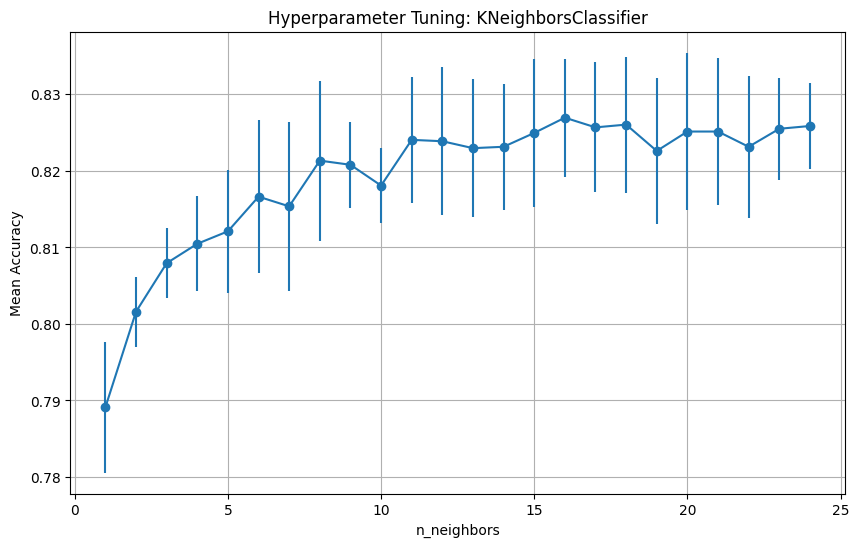

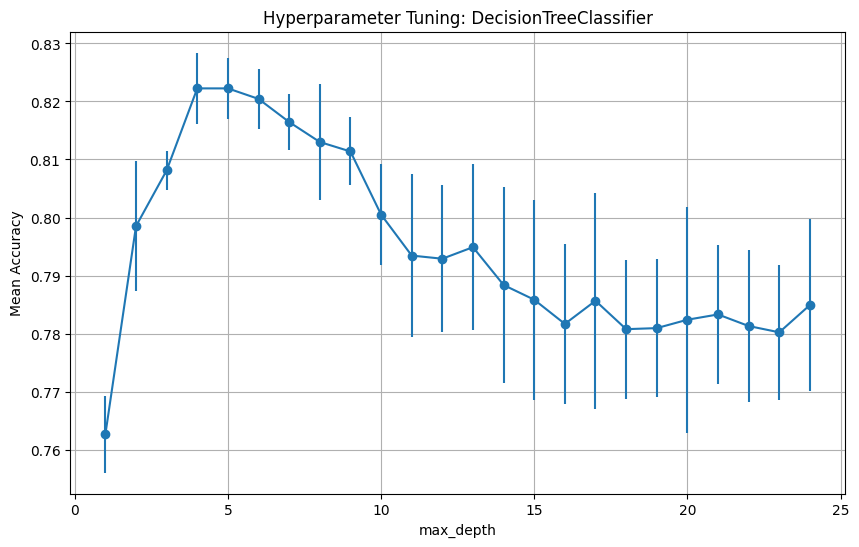

In [24]:
plot_hyperparameter_tuning(knn, 'n_neighbors', param_range_knn, train_data_pca_optimal, labels_train)

plot_hyperparameter_tuning(dt, 'max_depth', param_range_dt, train_data_pca_optimal, labels_train)


k-NN справился получше, но дольше, чем дерево. По тем же причинам, что были описаны при обработке без PCA

## Сравнение результатов

Сравните результаты полученные до трансформации данных с помощью PCA и после. Есть ли изменения динамики среднего значения качества по кросс-валидации алгоритма? Объясните почему?

PCA снижает размерность данных, сохраняя наиболее значимую информацию. Это уменьшает количество признаков, что может упростить модель и уменьшить риск переобучения. Немного изменилась динамика среднего значения качества по кросс-валидации алгоритма: получили оптимальное значение гиперпараметра меньше, чем без PCA, что позволяет быстрее обучать модель.

## Тестирование всех модели

Протестируйте все построенные модели (в т.ч. с и без PCA трансформации) на данных, которые были отложены для теста (их должно было остаться 40%). Не забудьте про все необходимые преобразования.

In [25]:
from sklearn.metrics import accuracy_score

# Обучение моделей
knn_optimal = KNeighborsClassifier(n_neighbors=21)
dt_optimal = DecisionTreeClassifier(max_depth=7)

knn_optimal.fit(train_data_fit, goal_var_train)
dt_optimal.fit(train_data_fit, goal_var_train)

knn_optimal_pca = KNeighborsClassifier(n_neighbors=14)
dt_optimal_pca = DecisionTreeClassifier(max_depth=3)

knn_optimal_pca.fit(train_data_pca_optimal, labels_train)
dt_optimal_pca.fit(train_data_pca_optimal, labels_train)

# Тестирование моделей
knn_accuracy = accuracy_score(goal_var_test, knn_optimal.predict(test_data_fit))
dt_accuracy = accuracy_score(goal_var_test, dt_optimal.predict(test_data_fit))

knn_accuracy_pca = accuracy_score(labels_test, knn_optimal_pca.predict(test_data_pca_optimal))
dt_accuracy_pca = accuracy_score(labels_test, dt_optimal_pca.predict(test_data_pca_optimal))

print(f"kNN Accuracy without PCA: {knn_accuracy}")
print(f"DecisionTree Accuracy without PCA: {dt_accuracy}")
print(f"kNN Accuracy with PCA: {knn_accuracy_pca}")
print(f"DecisionTree Accuracy with PCA: {dt_accuracy_pca}")

kNN Accuracy without PCA: 0.8092523212249552
DecisionTree Accuracy without PCA: 0.8139762176250204
kNN Accuracy with PCA: 0.8279044516829533
DecisionTree Accuracy with PCA: 0.8181324647122693
